# Classify names with character n-grams

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

from tqdm import tqdm_notebook

from local_settings import settings, datautils

## Overview of Data/Task
- Data compiled by [Sean Robertson](https://github.com/spro)
- Predict nationality from names.
- Data consist of 20074 names, 18 categories. 
- Russian names are dominant (skewing labels)
  - We downsample russian names to minimize the skew. Checkout the RNN tutorial for a different approach to handle label bias.

```
    2750 names_test.csv
   10994 names_train.csv
```

## Load names

In [52]:
name_data = pd.read_csv(settings.SURNAMES_CSV)

## Class Breakdown

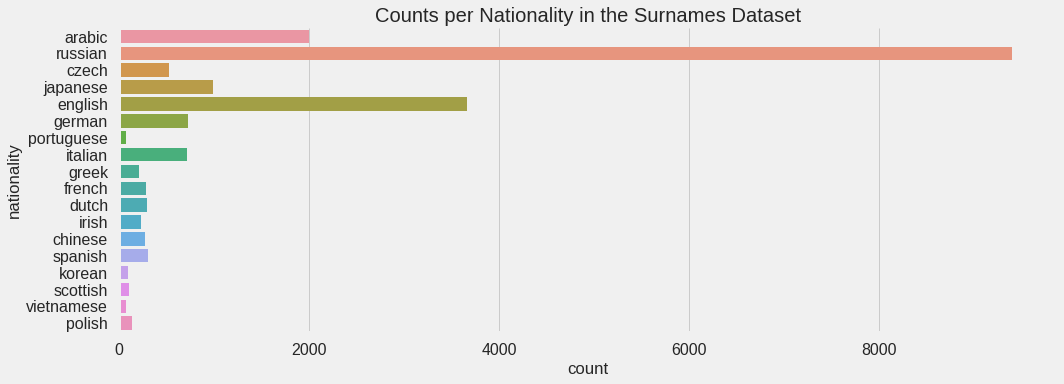

In [53]:
sns.factorplot(data=name_data, y='nationality', 
               kind='count', size=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset")

In [54]:
def fix_imbalance(df):
    median = df.groupby('nationality').agg('count').split.median()
    for nationality in df.nationality.unique():
        
        df_main = df[df.nationality != nationality]
        df_sub = df[df.nationality == nationality].reset_index(drop=True)
        if len(df_sub) > median:
            size = min(len(df_sub), int(median+0.05*len(df_sub)))
            indices = np.random.choice(np.arange(len(df_sub)), 
                                       size=size, 
                                       replace=False)
            df_sub = df_sub.iloc[indices]
        df = pd.concat([df_main, df_sub]).reset_index(drop=True)
    return df

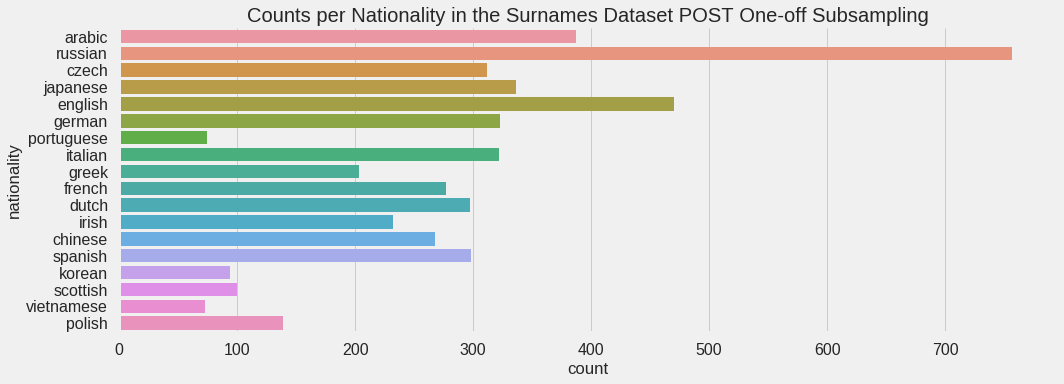

In [55]:
name_data = fix_imbalance(name_data)
sns.factorplot(data=name_data, y='nationality', 
               kind='count', size=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset POST One-off Subsampling")

# Feature Engineering

## 1. Lowercase

In [56]:
name_data['features'] = name_data['surname'].apply(lambda x: x.lower())
name_data.head()

,split,surname,nationality,features
0,train,Boutros,arabic,boutros
1,train,Kanaan,arabic,kanaan
2,train,Bitar,arabic,bitar
3,train,Sayegh,arabic,sayegh
4,train,Said,arabic,said


## 2. Add begin and end tokens


In [57]:
def add_begin_end_tokens(name):
    # return "^{}$".format(name)
    begin_token_marker = "^"
    end_token_marker = '$'
    return "".join((begin_token_marker, name, end_token_marker))

In [58]:
name_data['features'] = name_data['features'].apply(add_begin_end_tokens)
name_data.head()

,split,surname,nationality,features
0,train,Boutros,arabic,^boutros$
1,train,Kanaan,arabic,^kanaan$
2,train,Bitar,arabic,^bitar$
3,train,Sayegh,arabic,^sayegh$
4,train,Said,arabic,^said$


## 3. Extract Character N-grams

In [59]:
def extract_n_grams(tokens, n):
    '''
    param tokens: tokenized text
    return: list of n grams
    '''
    return [tokens[i:i + n] for i in range(len(tokens) - n + 1)]

In [60]:
# use trigrams
name_data['features'] = name_data['features'].apply(lambda x: extract_n_grams(x, 3))
name_data.head()

,split,surname,nationality,features
0,train,Boutros,arabic,"[^bo, bou, out, utr, tro, ros, os$]"
1,train,Kanaan,arabic,"[^ka, kan, ana, naa, aan, an$]"
2,train,Bitar,arabic,"[^bi, bit, ita, tar, ar$]"
3,train,Sayegh,arabic,"[^sa, say, aye, yeg, egh, gh$]"
4,train,Said,arabic,"[^sa, sai, aid, id$]"


## 4. Build vocabulary

In [61]:
vocabulary  = set()
for name in name_data['features'].values:
    [vocabulary.add(ngram) for ngram in name]        

In [62]:
maxlen = max(name_data['features'].apply(len))
maxlen

17

## 5. Map n-grams to indices

In [63]:
ngram_to_index = {ngram:i for i, ngram in enumerate(vocabulary)}

In [64]:
def n_grams_to_indices(n_grams):
    unknown_index = len(ngram_to_index) + 1
    return [ngram_to_index.get(ngram, unknown_index) for ngram in n_grams]  

In [65]:
n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])

[1408, 2808, 4668, 4139, 109]

## 6. Pad indices

In [66]:
def pad_indices(indices, maxlen=20):
    padded = np.zeros(maxlen, dtype=np.int64)
    for i, index in enumerate(indices):
        padded[i] = index
    return padded 

In [67]:
test_name = n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])
pad_indices(test_name, 20)

array([1408, 2808, 4668, 4139,  109,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

## 7. Encode class labels as numbers

In [68]:
label_to_number = {y: i for i, y in enumerate(set(name_data['nationality']))}
number_to_label = {i: y for i, y in enumerate(set(name_data['nationality']))}

In [69]:
label_to_number

{'arabic': 15,
 'chinese': 10,
 'czech': 2,
 'dutch': 6,
 'english': 3,
 'french': 17,
 'german': 12,
 'greek': 5,
 'irish': 13,
 'italian': 16,
 'japanese': 0,
 'korean': 7,
 'polish': 11,
 'portuguese': 4,
 'russian': 14,
 'scottish': 8,
 'spanish': 1,
 'vietnamese': 9}

## 8. Consolidate data preperation pipeline

In [70]:
import torch

In [71]:
def extract_name_features(name, n_grams=3):
    """
    Applies feature extraction pipeline to name
    """
    features = name.lower()
    features = add_begin_end_tokens(name)
    features = extract_n_grams(features, n_grams)
    features = n_grams_to_indices(features)
    features = pad_indices(features)
    features = torch.from_numpy(features).long()
    return features

In [72]:
extract_name_features('Brian')


 4907
 4907
 3908
 4830
 1839
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.LongTensor of size 20]

## Create PyTorch Dataset

In [73]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [74]:
class VectorizedSurnames(Dataset):
    """Name Classification dataset"""

    def __init__(self, data):
        '''
        Args:
            data (pandas.DataFrame)
        '''
        self.data = data
        self.x_surnames = self.data['surname'].apply(lambda x: extract_name_features(x, 3))
        self.y_nationalities = self.data['nationality'].apply(lambda x: label_to_number[x])

    @classmethod
    def from_file(cls, filename, split='train', apply_fix=True):
        df = pd.read_csv(settings.SURNAMES_CSV).dropna()
        df = df[df.split == split]
        if apply_fix:
            df = fix_imbalance(df)
        return cls(df)
    
    def __len__(self):
        return len(self.x_surnames)

    def __getitem__(self, index):
        return {'x_surnames': self.x_surnames.iloc[index],
                'y_nationalities': self.y_nationalities.iloc[index]}

In [75]:
name_dataset = VectorizedSurnames.from_file(settings.SURNAMES_CSV, split='train', apply_fix=True)

In [76]:
type(name_dataset.x_surnames[0])

torch.LongTensor

In [77]:
dataloader = DataLoader(name_dataset, batch_size=32, shuffle=True)

## Define MLP

In [78]:
import torch.nn as nn
import torch.nn.functional as F

In [110]:
class MLP(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, maxlen):
        super(MLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * maxlen, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x, apply_softmax=False):
        x = self.embeddings(x).view(-1, (embedding_dim * maxlen))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if apply_softmax:
            x = F.softmax(x)
        return x

In [111]:
vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 100 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20

mlp = MLP(vocab_size, embedding_dim, hidden_dim, output_size, maxlen)

## Define loss

In [112]:
criterion = nn.CrossEntropyLoss()

## Train

In [113]:
def train(model, dataloader, num_epochs):
    if settings.CUDA:
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    loss_history = []
    for i in range(num_epochs):
        for batch in dataloader:
            model.zero_grad()
            X = Variable(batch['x_surnames'])
            y = Variable(batch['y_nationalities'])
            if settings.CUDA:
                X = X.cuda()
                y = y.cuda()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        loss_history.append(loss.data[0])
        print('epoch[%d] log loss: %.4f' % (i, loss.data[0]))
    return loss_history

In [114]:
loss_history = train(mlp, dataloader, 30)

epoch[0] log loss: 2.3901
epoch[1] log loss: 2.0292
epoch[2] log loss: 1.8580
epoch[3] log loss: 1.7797
epoch[4] log loss: 0.9712
epoch[5] log loss: 0.6903
epoch[6] log loss: 0.8791
epoch[7] log loss: 0.6849
epoch[8] log loss: 0.4686
epoch[9] log loss: 0.4656
epoch[10] log loss: 0.4628
epoch[11] log loss: 0.5667
epoch[12] log loss: 0.1971
epoch[13] log loss: 0.3788
epoch[14] log loss: 0.4541
epoch[15] log loss: 0.3842
epoch[16] log loss: 0.3889
epoch[17] log loss: 0.1711
epoch[18] log loss: 0.2866
epoch[19] log loss: 0.6097
epoch[20] log loss: 0.2969
epoch[21] log loss: 0.2235
epoch[22] log loss: 0.2298
epoch[23] log loss: 0.0941
epoch[24] log loss: 0.2329
epoch[25] log loss: 0.2289
epoch[26] log loss: 0.2969
epoch[27] log loss: 0.2809
epoch[28] log loss: 0.1654
epoch[29] log loss: 0.1321
epoch[30] log loss: 0.2486
epoch[31] log loss: 0.1644
epoch[32] log loss: 0.1917
epoch[33] log loss: 0.3598
epoch[34] log loss: 0.3068
epoch[35] log loss: 0.1610
epoch[36] log loss: 0.1022
epoch[37] l

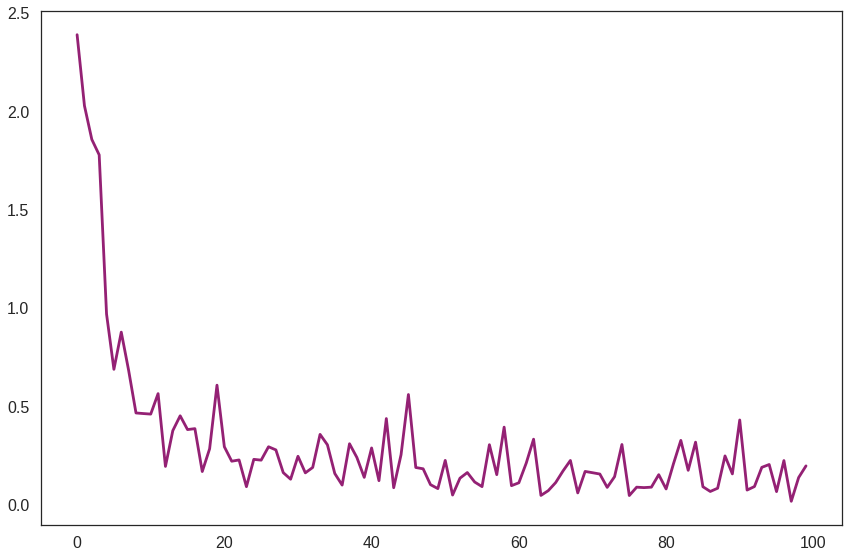

In [115]:
plt.plot(loss_history, color='#942174');

## save model

In [116]:
torch.save(mlp.state_dict(), 'names_mlp_model.state')

## load model

In [117]:
mlp.load_state_dict(torch.load('names_mlp_model.state'))

## Evaluate on test set

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score

def predict(model, dataloader):
    if settings.CUDA:
        model = model.cuda()
    else:
        model = model.cpu()
    ground_truth = []
    predictions = []
    for batch in dataloader:
        X = Variable(batch['x_surnames'])
        y = Variable(batch['y_nationalities'])
        if settings.CUDA:
            X = X.cuda()
            y = y.cuda()
        outputs = model(X)
        _, y_preds = torch.max(outputs, dim=1)
        ground_truth.append(y.data.cpu().numpy())
        predictions.append(y_preds.data.cpu().squeeze().numpy())
    return np.concatenate(ground_truth), np.concatenate(predictions)

In [119]:

name_dataset_test = VectorizedSurnames.from_file(settings.SURNAMES_CSV, split='test')
dataloader_test = DataLoader(name_dataset_test, batch_size=16, shuffle=True, num_workers=0)

mlp.train(False)
ground_truth, predictions = predict(mlp, dataloader_test)
print(accuracy_score(ground_truth, predictions)) # not relevant due to class imbalance

0.541463414634


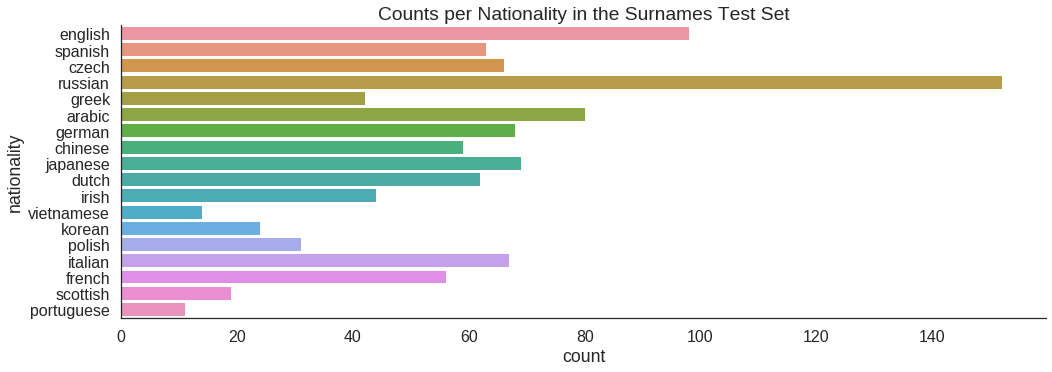

In [120]:
sns.factorplot(data=name_dataset_test.data, y='nationality', 
               kind='count', size=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Test Set")

In [94]:
labels

['japanese',
 'spanish',
 'czech',
 'english',
 'portuguese',
 'greek',
 'dutch',
 'korean',
 'scottish',
 'vietnamese',
 'chinese',
 'polish',
 'german',
 'irish',
 'russian',
 'arabic',
 'italian',
 'french']

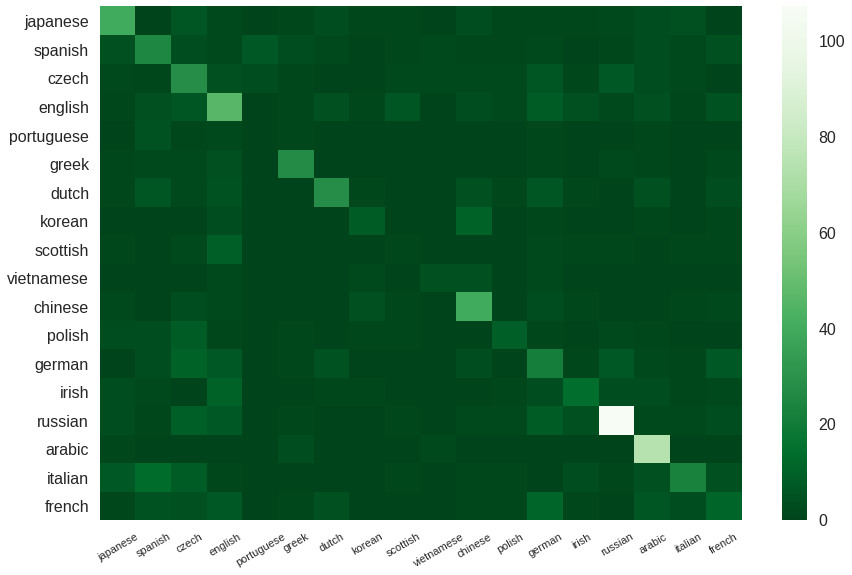

In [98]:
sns.set_style('white')
sns.set_context('poster')
labels = [number_to_label[i] for i in range(len(number_to_label))]
g = sns.heatmap(confusion_matrix(ground_truth, predictions), cmap='Greens_r');
g.set_xticklabels(labels, rotation=30, size=11);
g.set_yticklabels(labels[::-1], rotation=0);

## Exersize: run your name through the model

In [97]:
name = extract_name_features('mcmahan')
name = name.view(1,-1) # reshape because model expects a batch
if settings.CUDA:
    preds = mlp(Variable(name).cuda(), apply_softmax=True)
else:
    preds = mlp(Variable(name), apply_softmax=True)
top_pred, index = torch.max(preds, dim=1)
number_to_label[index.data.tolist()[0]]

'irish'